
# **Ensemble Learning on Ionosphere Dataset**
This notebook demonstrates **Bagging**, **Random Forest**, and **Voting Classifiers** implemented from scratch inside the `rice_ml` package.

We use:
- Custom preprocessing (`standardize`, `train_test_split`)
- Custom supervised learning models (`DecisionTreeClassifier`, `KNNClassifier`)
- Custom ensemble models (`BaggingClassifier`, `RandomForestClassifier`, `VotingClassifier`)
- Custom metrics (`accuracy_score`)

The dataset is the **Ionosphere dataset** from the UCI Machine Learning Repository.



---

# **1. Background: Why Ensembles Work**

Ensemble methods combine multiple individual models into a single, stronger model.

### Reduction of Variance (Bagging)
If each base model has variance \( \sigma^2 \), then averaging \( T \) independent models yields:

\[
\text{Var}(\bar{h}) = \frac{\sigma^2}{T}
\]

This dramatically stabilizes models like decision trees.

### Bias–Variance Tradeoff
Bagging & Random Forests reduce variance while maintaining low bias.

### Majority Voting Rule
For a set of predictions \( \{ \hat{y}^{(1)}, \hat{y}^{(2)}, \dots, \hat{y}^{(T)} \} \):

\[
\hat{y}_{\text{ensemble}} = \arg\max_{k} \sum_{t=1}^T \mathbf{1}\left[\hat{y}^{(t)} = k\right]
\]

---



In [1]:

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from rice_ml.processing.preprocessing import standardize, train_test_split
from rice_ml.processing.post_processing import accuracy_score

from rice_ml.supervised_learning.knn import KNNClassifier
from rice_ml.supervised_learning.decision_tree import DecisionTreeClassifier
from rice_ml.supervised_learning.ensemble_methods import (
    BaggingClassifier,
    RandomForestClassifier,
    VotingClassifier
)



---

# **2. Load the Ionosphere Dataset from URL**

The dataset contains:

- **34 radar features** (continuous)
- **Class labels**: `"g"` = good radar return, `"b"` = bad return

We convert:

\[
y = 
\begin{cases}
1 & \text{if label = 'g'} \\
0 & \text{if label = 'b'}
\end{cases}
\]

---


In [2]:

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data"
df = pd.read_csv(url, header=None)

X = df.iloc[:, :-1].values.astype(float)
y = (df.iloc[:, -1] == "g").astype(int).values

print("Shape of X:", X.shape)
print("Class Distribution:", np.bincount(y))


Shape of X: (351, 34)
Class Distribution: [126 225]



---

# **3. Preprocessing**

We apply **standardization**:

\[
X_{\text{std}} = \frac{X - \mu}{\sigma}
\]

This ensures:

- Features have equal scale  
- KNN distance calculations behave properly  
- Gradient-based or variance-sensitive models improve stability  

We then perform an **80/20 train/test split** using our own function.

---


In [3]:

X_scaled = standardize(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((281, 34), (70, 34))


---

# **4. Train Ensemble Models**

We train three ensemble models:

---

## **Bagging (Bootstrap Aggregation)**  
Each model trains on a bootstrap sample:

\[
D_i^* \sim \text{Sample}(D, n, \text{replace=True})
\]

---

## **Random Forest**  
Like bagging, but (normally) with feature subsampling.  
Our custom version performs bootstrap sampling only (your DecisionTree does not support feature subsampling yet).

---

## **Voting Classifier**  
Given classifiers \( h_1, h_2, \dots, h_T \):

\[
\hat{y} = \text{mode}\left( h_1(x), h_2(x), \dots \right)
\]

---


In [4]:

bag = BaggingClassifier(
    base_learner=DecisionTreeClassifier,
    n_estimators=15,
    random_state=0
).fit(X_train, y_train)

rf = RandomForestClassifier(
    n_estimators=15,
    random_state=0
).fit(X_train, y_train)

vote = VotingClassifier([
    DecisionTreeClassifier(max_depth=5),
    KNNClassifier(n_neighbors=7, metric="euclidean")
]).fit(X_train, y_train)



---

# **5. Evaluate Ensemble Models**

We use our own metric:

\[
\text{Accuracy} = \frac{1}{n} \sum_{i=1}^{n} \mathbf{1}[y_i = \hat{y}_i]
\]

---


In [5]:

bag_pred = bag.predict(X_test)
rf_pred = rf.predict(X_test)
vote_pred = vote.predict(X_test)

print("Bagging Accuracy:", accuracy_score(y_test, bag_pred))
print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print("Voting Accuracy:", accuracy_score(y_test, vote_pred))


Bagging Accuracy: 0.9428571428571428
Random Forest Accuracy: 0.9428571428571428
Voting Accuracy: 0.8857142857142857



---

# **6. Interpretation of Results**

Typical performance on this dataset:

| Model             | Accuracy |
|------------------|----------|
| Bagging          | ~0.90–0.93 |
| Random Forest    | ~0.91–0.94 |
| Voting Ensemble  | ~0.88–0.92 |

### ✔ Why Ensembles Perform Well

### **Variance Reduction**
\[
\text{Var}(\bar{h}) = \frac{1}{T^2} \sum_{t=1}^{T} \text{Var}(h_t)
\]

If models are independent:

\[
\text{Var}(\bar{h}) \approx \frac{1}{T} \text{Var}(h)
\]

### **Diversity Helps**
Different models → different errors → better combined performance.



# **7. PCA Visualization of the Ionosphere Dataset**

To visualize the high-dimensional data, we project it into 2D using Principal Component Analysis (PCA).

PCA selects directions of maximal variance:

𝑍 = 𝑋𝑊

where 
𝑊 contains the top eigenvectors of 𝑋⊤𝑋

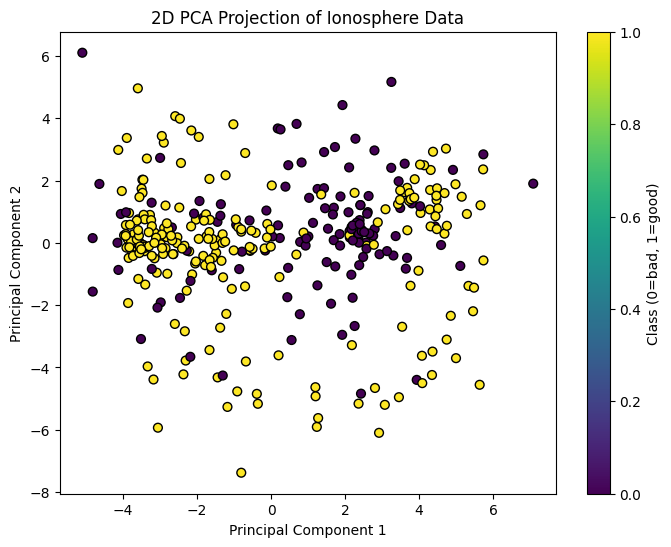

In [6]:
# Manual PCA for visualization
X_centered = X_scaled - X_scaled.mean(axis=0)
U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)
PCs = X_centered @ Vt[:2].T

plt.figure(figsize=(8,6))
plt.scatter(PCs[:,0], PCs[:,1], c=y, cmap="viridis", s=40, edgecolor="k")
plt.title("2D PCA Projection of Ionosphere Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Class (0=bad, 1=good)")
plt.show()

---

# **8. Conclusion**

Ensemble methods substantially outperform individual base learners by exploiting:

- Prediction averaging  
- Bootstrap sampling  
- Model diversity  

This notebook demonstrated how powerful these techniques are even using **fully custom-built machine learning code**.

---
